# accuracy_score
- 전체 중 예측을 잘 한 것의 비율
- sklearn.metrics.accuracy_score
- sklearn.metrics.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)

# precision_score
- POS로 예측한 것 중 실제도 POS인 비율
- sklearn.metrics.precision_score
- sklearn.metrics.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

# recall_score
- 실제 POS인 것 중 예측도 POS로 한 것의 비율
- sklearn.metrics.recall_score
- sklearn.metrics.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

# f1_score
- precision과 recall의 조화평균
- sklearn.metrics.f1_score
- sklearn.metrics.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

# 함수로 표현

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1score = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, f1score: {3:.4f}'.format(accuracy, precision, recall, f1score))

# 타이타닉 예제 적용

## 전처리

In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df_titanic = pd.read_csv('./datasets/titanic_train.csv')
df_titanic = df_titanic.loc[:,['Survived', 'Sex', 'Age', 'Pclass']]
X = df_titanic.loc[:,['Sex', 'Age', 'Pclass']]
y = df_titanic['Survived']
X['Age'].fillna(method='ffill', inplace=True)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(X['Sex'])
X['Sex'] = labels

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X[['Age']])
age_scaled = scaler.transform(X[['Age']])
X['Age']=age_scaled

## confusion matrix 구하기
- binarizer 이용하지 않고 predict 하는 경우에는 확률 높은 값으로 분류됨

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[101  17]
 [ 12  49]]
정확도: 0.8380, 정밀도: 0.7424, 재현율: 0.8033, f1score: 0.7717


## 1과 0 분류 확률 중 큰 것으로 분류

In [21]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 학인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n',pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.42558527 0.57441473]
 [0.88833758 0.11166242]
 [0.88651722 0.11348278]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.42558527 0.57441473 1.        ]
 [0.88833758 0.11166242 0.        ]
 [0.88651722 0.11348278 0.        ]]


## 임계값에 따른 분류 - 0.5인 경우
- threshold 값보다 크면 1으로 분류되므로 predict_proba() 반환값의 두번째 컬럼 positive 클래스 컬럼 이용

In [24]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값 분류 결정 임계값
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 컬럼, 즉 positive 클래스 컬럼 하나만 추출하여 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[101  17]
 [ 12  49]]
정확도: 0.8380, 정밀도: 0.7424, 재현율: 0.8033, f1score: 0.7717


## 임계값에 따른 분류 - 0.4인 경우

In [25]:
from sklearn.preprocessing import Binarizer

custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[94 24]
 [10 51]]
정확도: 0.8101, 정밀도: 0.6800, 재현율: 0.8361, f1score: 0.7500


## 위 값을 이용한 결과
- 재현율을 중요시 한다면 0.4를 기준으로
- 재현율과 정밀도 둘 다 중요시 한다면 0.4를 기준으로

## threshold 함수 만들어 돌리기

In [26]:
from sklearn.preprocessing import Binarizer

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #threshold list 객체 내 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.4
오차행렬
[[94 24]
 [10 51]]
정확도: 0.8101, 정밀도: 0.6800, 재현율: 0.8361, f1score: 0.7500
임계값: 0.45
오차행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, f1score: 0.7576
임계값: 0.5
오차행렬
[[101  17]
 [ 12  49]]
정확도: 0.8380, 정밀도: 0.7424, 재현율: 0.8033, f1score: 0.7717
임계값: 0.55
오차행렬
[[107  11]
 [ 17  44]]
정확도: 0.8436, 정밀도: 0.8000, 재현율: 0.7213, f1score: 0.7586
임계값: 0.6
오차행렬
[[111   7]
 [ 21  40]]
정확도: 0.8436, 정밀도: 0.8511, 재현율: 0.6557, f1score: 0.7407


## precision_recall_curve()로 정밀도-재현율 값 추출
- sklearn.metrics.plot_precision_recall_curve
- sklearn.metrics.plot_precision_recall_curve(estimator, X, y, *, sample_weight=None, response_method='auto', name=None, ax=None, pos_label=None, **kwargs)

In [39]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터셋과 레이블값이 1일 떄의 예측 확률을 precision_recall_curve인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

print('반환된 분류 결정 임곗값 배열의 shape', thresholds.shape)
print('반환된 precisions 배열의 shape', precisions.shape)
print('반환된 recalls 배열의 shape', recalls.shape)

print("\nthresholds 5 samples:", thresholds[:5]) # thresholdsndarray of shape (n_thresholds,)
print("precisions 5 samples:", precisions[:5]) # precisionndarray of shape (n_thresholds + 1,)
print("recalls 5 samples:", recalls[:5]) # recallndarray of shape (n_thresholds + 1,)

반환된 분류 결정 임곗값 배열의 shape (124,)
반환된 precisions 배열의 shape (125,)
반환된 recalls 배열의 shape (125,)

thresholds 5 samples: [0.06556004 0.07136752 0.0776467  0.07896181 0.08303016]
precisions 5 samples: [0.34078212 0.34269663 0.34659091 0.35057471 0.35465116]
recalls 5 samples: [1. 1. 1. 1. 1.]


## precision_recall_curve() 시각화

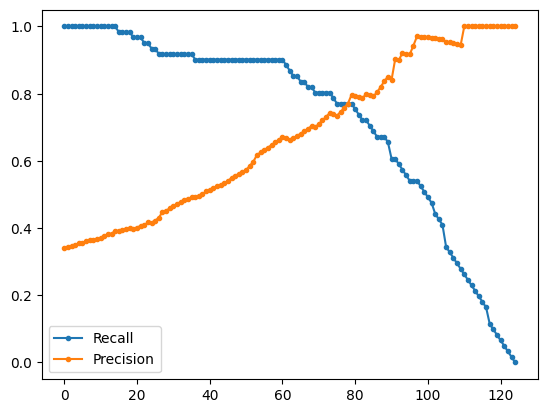

In [40]:
import matplotlib.pyplot as plt

plt.plot(recalls, marker='.', label = 'Recall')
plt.plot(precisions, marker='.', label = 'Precision')

plt.legend()
plt.show()

## ROC 곡선
- sklearn.metrics.roc_curve
- sklearn.metrics.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)
- fpr = False Positive Rate : 1-특이도
- tpr = True Positive Rate : 민감도

In [50]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추측
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
# threshold[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작 
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index],2))

# 5 step으로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51 56 61 66]
샘플 index로 추출한 임곗값: [0.95 0.81 0.65 0.6  0.55 0.47 0.4  0.27 0.18 0.13 0.12 0.11 0.1  0.08]
샘플 임계값별 FPR:  [0.    0.008 0.025 0.059 0.102 0.178 0.212 0.314 0.466 0.542 0.678 0.754
 0.839 0.941]
샘플 임계값별 TPR:  [0.016 0.344 0.541 0.656 0.721 0.803 0.852 0.902 0.902 0.918 0.934 0.967
 1.    1.   ]


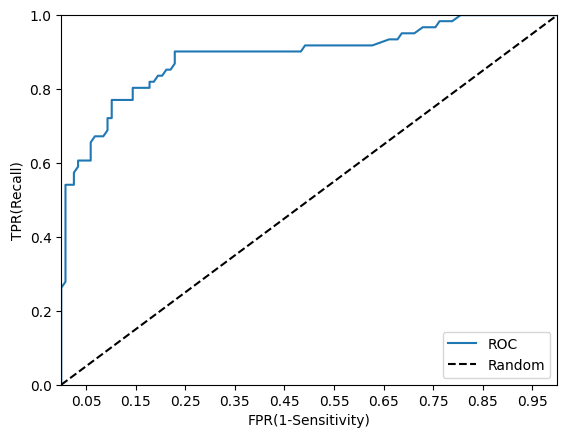

In [57]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC Curve를 plot 곡선으로 그림
    plt.plot(fprs, tprs, label = 'ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 scale을 0.1 단위로 변경, X, Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, pred_proba_class1)

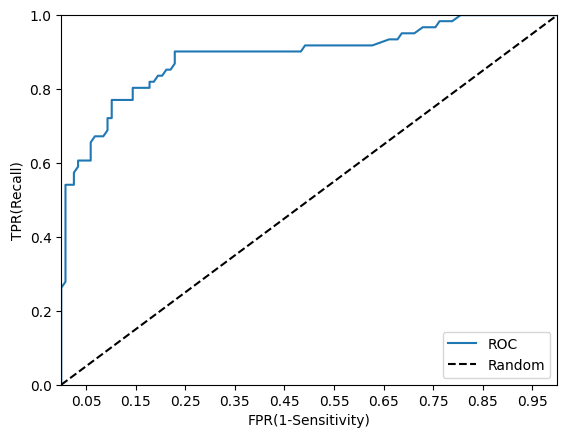

In [55]:
plt.plot(fprs, tprs, label = 'ROC')
# 가운데 대각선 직선을 그림
plt.plot([0,1], [0,1], 'k--', label='Random')
    
# FPR X축의 scale을 0.1 단위로 변경, X, Y 축명 설정등
start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1), 2))
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
plt.legend()
plt.show()

## AUC 스코어

In [58]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0: .4f}'.format(roc_score))

ROC AUC 값:  0.8900
